# ECON 8185 - HW 3

João Lazzaro - santo279@umn.edu

## Question 1

In this question we were asked to write a code to compute the MLE estimator for the parameters of HW2 model: 

$$\max_{c_t,x_t,l_t} E \sum_{t=0}^\infty \beta^t \frac{\left(c_tl_t^\psi\right)^{1-\sigma}}{1-\sigma} N_t$$
S.T. 
$$ c_t +(1+\tau_{xt})x_t =r_t k_t +(1-\tau_{ht})w_t h_t + T_t$$
$$ N_{t+1} k_{t+1} = [(1-\delta)k_t+x_t]N_t$$
$$h_t+l_t =1$$
$$S_t = P S_{t-1}+Q\epsilon_t,\;\;S_t = [\ln z_t,\tau_{ht},\tau_{xt}, \ln g_t]$$
$$ c_t,x_t\geq0$$

Where $N_t = (1+\gamma_n)^t$ and firm tecnhology is $Y_t = K_t^\theta (Z_t L_t)^{1-\theta}$. $\gamma_z$ is the rate of labor-augmenting technical progress. The stochastic shocks hitting this economy affect technology, tax rates, and government spending and the stochastic processes are modeled as a VAR(1) process. The resource constraint is $Y_t=N_t(c_t +x_t +g_t)$. We must work with detrended variables, we should use "hat" variables, but typing this is time consuming so from now on all variables should be understood as detrended unless I say something about them.

Let's first define some parameters for this model:

In [1]:
using NLsolve, ForwardDiff, LinearAlgebra, Random, JLD2,FileIO
using Optim, Statistics, NLSolversBase,LaTeXStrings, Plots

#Parameters:
δ = 0.0464   #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
σ = 2  #Elasticity of Intertemporal Substitution
ψ = 1    #Labor parameter
γn= 0.00    #Population growth rate
γz= 0.00   #Productivitu growth rate

0.0

We'll assume, for now, that matrices P and Q are the following:

In [2]:
#Parameters to be estimated and here used in our simulated example
gss = log(0.01) #average g (in logs)
τxss = 0.05 #average τx
τhss = 0.02 #average τh
zss = log(1) #average z (z is in logs)

#Parameters to be estimated
ρg = 0.25
ρx = 0.5
ρh = 0.75
ρz = 0.95
ρzg= 0.0
ρzx = 0.0
ρzh = 0.0
ρhz = 0.0
ρhx = 0.0
ρhg = 0.0
ρxz = 0.0
ρxh = 0.0
ρxg = 0.0
ρgz = 0.0
ρgx = 0.
ρgh = 0.

σg= 0.04
σx = 0.02
σz = 0.05
σh = 0.03
σzg= 0.0
σzx = 0.00
σzh = 0.00
σhx = 0.00
σhg = 0.00
σxg = 0.00

#In matrix form
P = [ρz ρzh ρzx ρzg;
ρhz ρh ρhx ρhg ;
ρxz ρxh ρx ρxg ;
ρgz ρgh ρgx ρg]
Q = [σz σzh σzx σzg;
σzh σh σhx σhg ;
σzx σhx σx σxg ;
σzg σhg σxg σg]
P,Q

([0.95 0.0 0.0 0.0; 0.0 0.75 0.0 0.0; 0.0 0.0 0.5 0.0; 0.0 0.0 0.0 0.25], [0.05 0.0 0.0 0.0; 0.0 0.03 0.0 0.0; 0.0 0.0 0.02 0.0; 0.0 0.0 0.0 0.04])

In HW2, I describe how to approximate and write the model in the state space form:
$$ X_{t+1} = AX_t + B \varepsilon_{t+1}$$
$$Y_t = CX_t+\omega_t$$
Where, $X_t = [k_t,S_t],S_t=[z_t,\tau_{ht},\tau_{xt},g_t]$, $Y_t = [y_t,x_t,h_t]$ and as before:
$$S_{t+1} = P S_t +Q \varepsilon_{t+1}$$

The function below, defined in HW2, finds Matrices $A,B$ and $C$, given pthe parameters:

In [3]:
include("State_Space.jl")

params_calibrated = [δ,θ,β,σ,ψ,γn,γz,]
steadystates = [gss,τxss,τhss,zss]

A,B,C = State_Space(params_calibrated,steadystates, P,Q)

([0.837775 0.104932 … -0.00873318 -0.00503954; 0.0 0.95 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.25], [0.0 0.0 … 0.0 0.0; 0.0 0.05 … 0.0 0.0; … ; 0.0 0.0 … 0.02 0.0; 0.0 0.0 … 0.0 0.04], [0.462735 0.723595 … -0.00725865 0.00267248; -2.49623 2.2615 … -0.188215 -0.108611; 0.1941 0.0853944 … -0.0108879 0.00400872; 0.0 0.0 … 0.0 1.0])

Given the model we simulate some data:

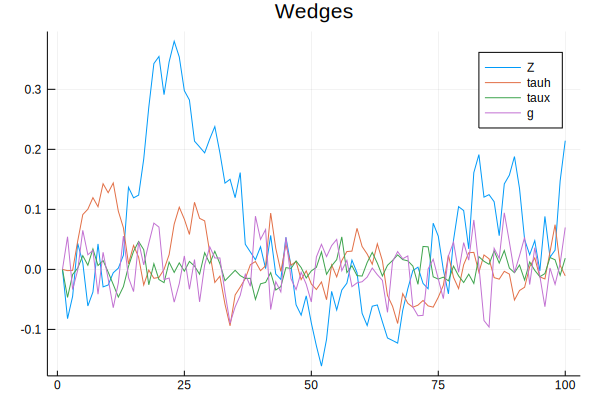

In [4]:
T=100
X= zeros(5,T)
Y = zeros(4,T)

Random.seed!(0403);
S = randn(5,T) #vector with shocks

#Simulating data
for t=1:T
    if t>1
    X[:,t] = A*X[:,t-1]+ B*S[:,t]
    end
    Y[:,t] = C*X[:,t]
end
plot([X[2,:],X[3,:],X[4,:],X[5,:]],title ="Wedges", labels = ["Z","tauh","taux","g"])

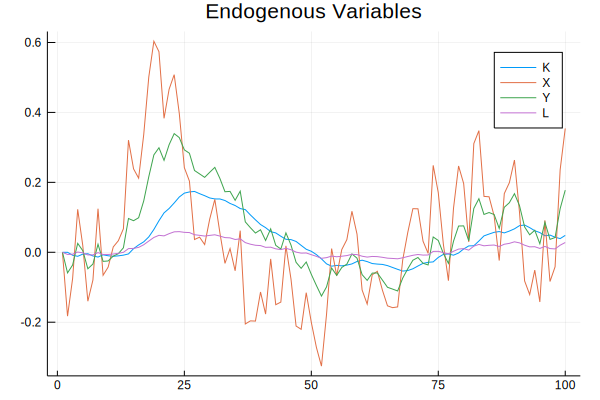

In [5]:
plot([X[1,:],Y[2,:],Y[1,:],Y[3,:]],title = "Endogenous Variables",labels = ["K","X","Y","L"])

Given the simulated data above, we want to build an algorithm to estimate the matrices P and Q (and the steady state values) such that we would have the same data generating process. To do that, we'll build a likelihood function using the Kalman Filter. We follow Ljunqvist & Sargent exposition of the Kalman filter. Assume for a slightly more general case that $\omega_t$ is an iid vector sequence of normal random variances with mean zero and covariance matrix $R$ (In our case, $R=0$).  

We observe $Y_t$ but not $X_t$. We want to estimate $\hat{X}_t = E[X_t|Y^{t-1}]$ and also the covariances $\Sigma_t = E[(X_t-\hat{X}_t)(X_t-\hat{X}_t)']$. The trick is to use the new information in $y_0$ relative to what we know ($\hat{X}_0$):    $a_0:=Y_0-C\hat{X}_0$. $a_t:=Y_t-C\hat{X}_t$. Regressing the model: $$X_0-\hat{X}_0 = L_0a_0+\eta$$ We get that:
$$L_0 = \Sigma_0 C'\left(C\Sigma_0 C'+R\right)^{-1} $$

Defining $\hat{X}_1 = E[X_1|Y_0] = A X_0$: 
$$X_1 = A\hat{X}_0 + A\left(X_0-\hat{X}_0\right) + B \varepsilon_1$$

Substituting the linear model and $L_0$:
$$\hat{X}_1 = A\hat{X}_0 +K_0(Y_0 - C \hat{X}_0) $$

Where $K_0 = AL_0$ is the Kalman gain. Plugging these equations: $X_1-\hat{X}_1 = A (X_0-\hat{X}_0) +B \varepsilon_1 - K_0(Y_0-C\hat{X}_0)$ and we may compute a new variance matrix $\Sigma_1 = E(X_1-\hat{X}_1)(X_1-\hat{X}_1)$:
$$\Sigma_1 = (A-K_0C)\Sigma_0(A-K_0C)' + (BB'+K_0RK_0')$$


Iterating the above steps we get te Kalman filter recursion:
$$a_t = Y_t-C\hat{X}_t$$
$$K_t = A\Sigma_tC'(C\Sigma_tC'+R)^{-1}$$
$$\hat{X}_{t+1} = A\hat{X}_t + K_t a_t$$
$$\Sigma_{t+1} = (A-K_tC)\Sigma_t(A-K_tC)' + (BB'+K_tRK_t')$$

The code below implements this recursion:

In [6]:
function KalmanFilter(Y,A,B,C)
#Y: Observed variables


n = size(A)[1] #number of state variables
m = size(C)[1] #number of measurement variables
T = size(Y)[2] #Sample size

#Initializing the state variables
X = zeros(n,T)
#Variance initial guess
Σ = ones(n,n)*ones(n,n)'
d=10
while d>10^(-15)
    Σ1 = A*Σ*A' + B*B'
    d = maximum(abs.(Σ-Σ1))
    Σ=Σ1
end

#Run the Kalman filter algorithm (see Ljunqvist sargent)
a=ones(m,T)
Ω = C*Σ*C'
Σhist = copy(Σ)
for t = 1:T-1
    a[:,t] = Y[:,t] - C*X[:,t]
    K = A*Σ*C' / (C*Σ*C')
    X[:,t+1] = A*X[:,t] +K*a[:,t]
    Σ = B*B' + (A-K*C)*Σ*(A-K*C)'
    Σhist = [Σhist Σ]
    Ω = [Ω C*Σ*C']
end
a[:,T] = Y[:,T] - C*X[:,T]
Ω = [Ω C*Σ*C']

return X, a, Ω, Σhist
end

KalmanFilter (generic function with 1 method)

Note that we set, in the code above, the initial $\Sigma_0$ such that $\Sigma_0 = A\Sigma_0A' +BB$. 

The innovations representation that emerges from the Kalman filter is: 
$$\hat{X}_{t+1} = A\hat{X}_t+K_t a_t$$
$$Y_t = C \hat{X}_t +a_t $$
Define: $\Omega_t :=E[a_ta'_t] = C \Sigma_tC'+R$. We have that $E[Y_t|Y^{t-1}] = C\hat{X}_t$ and the conditional distribution of $Y_t$ is $N(C\hat{X}_t,\Omega_t)$. Therefore, $C\hat{X}_t,\Omega_t$ are sufficient statistics for the conditional distribution of $Y_t$. Note that we can factor the likelihood function as:
$$f(Y_T,...Y_0) = f(Y_T|Y^{T-1})f(Y_{T-1}|Y^{T-2})...f(Y_1|Y_0)f(Y_0)$$

And the log of the conditional density of the $m \times 1$ vector $Y_t$, ignoring constant terms, is:
$$\log f(Y_t|Y^{t-1}) =- 0.5 \log(|\Omega_t|) -0.5 a_t'\Omega_t^{-1} a_t$$

The code below builds the log conditional likelihood function using the method above:

In [7]:
function likelihood(Y,Ω,a)
    m,T = size(Y)
    L = 0
for t=1:T
    iteration = t
    L = L + (-0.5*log(det(Ω[:,m*t-(m-1):(m*t)])) -
    0.5*a[:,t]'*(Ω[:,m*t-(m-1):(m*t)]\a[:,t]))
end
return L
end

likelihood (generic function with 1 method)

We can estimate parameters $\theta$ given a vector of data $Y$ by maximizing the log likelihood function.

Now, back to our exercise, the code below we may define the subset of parameters to be estimated and writes down a function to in the optimizer format.

In [8]:
function maxloglikelihood(vector::Vector;Y=Y)
    #ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    ρg,ρx,ρh,ρz=vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

Note that the function above actually returns minus the log likelihood, since our optimizer is in fact a minimizer. Checking the value of 

## Question 2

We first begin estimating only 4 parameters and assuming all the others are known:

In [9]:
original = [ρg,ρx,ρh,ρz]

4-element Array{Float64,1}:
 0.25
 0.5 
 0.75
 0.95

The likelihood valued at the true parameters is:

In [10]:
truelikelihood = maxloglikelihood(original)

-1810.7834564467269

In [11]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.5

#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()

#Defining lower and upper bounds for estimator
lower=zeros(length(initial))
upper = ones(length(initial))
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


@time bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer), Optim.Options(show_trace = false, show_every = 10,iterations =500, time_limit = 60*60*1.0))
estimates = bla.minimizer

 11.014312 seconds (28.22 M allocations: 4.644 GiB, 12.77% gc time)


4-element Array{Float64,1}:
 0.25115834217496663
 0.3724996508964938 
 0.793569282405732  
 0.9501104708862674 

The optimizer found the parameters above, note that they are reasonably, close to the true parameters:

In [12]:
abs.(estimates - original)

4-element Array{Float64,1}:
 0.0011583421749666312 
 0.12750034910350622   
 0.04356928240573199   
 0.00011047088626747747

Now we repeat the exercise increasing the sample size:

In [13]:
T=600
X= zeros(5,T)
Y = zeros(4,T)

Random.seed!(0403);
S = randn(5,T) #vector with shocks

#Simulating data
for t=1:T
    if t>1
    X[:,t] = A*X[:,t-1]+ B*S[:,t]
    end
    Y[:,t] = C*X[:,t]
end

Random.seed!(0403);
initial = original .+ randn(length(original))*0.5

#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()

#Defining lower and upper bounds for estimator
lower=zeros(length(initial))
upper = ones(length(initial))
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),Optim.Options(show_trace = false, show_every = 10,iterations =500, time_limit = 60*60*1.0))
estimates = bla.minimizer

4-element Array{Float64,1}:
 0.2723726668152855 
 0.47735552054898267
 0.7930228169543113 
 0.9499548713942856 

The estimation improved considerably for most parameters:

In [14]:
abs.(estimates - original)

4-element Array{Float64,1}:
 0.02237266681528549 
 0.02264447945101733 
 0.043022816954311316
 4.512860571437294e-5

We keep this new sample size and now, we estimate 8 parameters in total:

In [15]:
function maxloglikelihood(vector::Vector;Y=Y)
    ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    #ρg,ρx,ρh,ρz=vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

The parameters being estimated are:

In [16]:
original = [ ρg,ρx,ρh,ρz,σg,σx,σz,σh]

8-element Array{Float64,1}:
 0.25
 0.5 
 0.75
 0.95
 0.04
 0.02
 0.05
 0.03

In [17]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.5

#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()

#Defining lower and upper bounds for estimator
lower=zeros(length(initial))
upper = ones(length(initial))
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),
    Optim.Options(show_trace = false, show_every = 10,iterations =500, time_limit = 60*60*1.0))
estimates = bla.minimizer

8-element Array{Float64,1}:
 0.2723645656724342  
 0.4167003617213166  
 0.785577891881518   
 0.9499289341748347  
 0.04020397171301103 
 0.01924533114728138 
 0.049201046279740715
 0.02937510753750426 

The estimation is also good:

In [18]:
abs.(estimates - original)

8-element Array{Float64,1}:
 0.022364565672434222 
 0.08329963827868342  
 0.03557789188151805  
 7.106582516525073e-5 
 0.0002039717130110294
 0.0007546688527186214
 0.0007989537202592878
 0.000624892462495738 

Now, we estimate all the Parameters with the exception of the Steady States and things start to get a little trickier:

In [19]:
function maxloglikelihood(vector::Vector;Y=Y)
    #ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    #ρg,ρx,ρh,ρz=vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

In [20]:
original = [ ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg]

26-element Array{Float64,1}:
 0.25
 0.5 
 0.75
 0.95
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.04
 0.02
 0.05
 0.03
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 

In [21]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.1


#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()


#Defining lower and upper bounds for estimator
lower=zeros(length(initial))

upper = ones(length(initial))
if length(initial) == 8
    upper[5:8] = 0.05 *ones(4)
end
if length(initial)>16
    upper[17:26] = 0.05.*ones(10)
    lower[5:16] = -1*ones(12)
end
if length(initial) == 30
    upper[27:30] = 0.1 * ones(4)
    lower[30] = -100 #z lower bound (in logs)
    lower[27] = -100 #g lower bound (in logs)
end
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),Optim.Options(show_trace = false, show_every = 5,iterations =500, time_limit = 60*60*1.0))

estimates = bla.minimizer

26-element Array{Float64,1}:
  0.25004981360031103   
  0.6119478860387452    
  0.7639511650799191    
  0.9506382987977844    
  0.011444298587707043  
  0.05576119548843076   
 -0.017117135923860924  
  0.11764568705420364   
 -0.23370018286402613   
  0.11113444851509129   
 -0.08785411725096931   
  0.11430128828900515   
 -0.012876737753601273  
  0.10185922945730956   
 -0.12333296914003349   
  0.0858541414221549    
  0.029484599362833434  
  0.03336868072155079   
  0.049999999999999996  
  0.0036634851089904883 
  1.6339378666581182e-36
  0.012688886388084391  
  0.022404835517535148  
  0.006290960682810969  
  0.043483347234460595  
  6.2477573278445315e-19

The estimates are fair:

In [22]:
abs.(estimates - original)

26-element Array{Float64,1}:
 4.981360031103277e-5  
 0.11194788603874517   
 0.013951165079919114  
 0.0006382987977844312 
 0.011444298587707043  
 0.05576119548843076   
 0.017117135923860924  
 0.11764568705420364   
 0.23370018286402613   
 0.11113444851509129   
 0.08785411725096931   
 0.11430128828900515   
 0.012876737753601273  
 0.10185922945730956   
 0.12333296914003349   
 0.0858541414221549    
 0.010515400637166567  
 0.013368680721550789  
 6.938893903907228e-18 
 0.02633651489100951   
 1.6339378666581182e-36
 0.012688886388084391  
 0.022404835517535148  
 0.006290960682810969  
 0.043483347234460595  
 6.2477573278445315e-19

Now, estimating all the 30 parameters:

In [23]:
function maxloglikelihood(vector::Vector;Y=Y)
    #ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    #ρg,ρx,ρh,ρz=vector
    ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

In [24]:
original = [ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss]

30-element Array{Float64,1}:
  0.25             
  0.5              
  0.75             
  0.95             
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  ⋮                
  0.05             
  0.03             
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
 -4.605170185988091
  0.05             
  0.02             
  0.0              

In [50]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.1
initial[5:30] = 0*original[5:30] .+rand(length(original[5:30]))*0.1



#Solver Stuff

inner_optimizer = LBFGS( ) #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()


#Defining lower and upper bounds for estimator
lower=zeros(length(initial))

upper = ones(length(initial))
if length(initial) == 8
    upper[5:8] = 0.05 *ones(4)
end
if length(initial)>16
    upper[17:26] = 0.05.*ones(10)
    lower[5:16] = -1*ones(12)
end
if length(initial) == 30
    upper[27:30] = 0.1 * ones(4)
    lower[30] = -100 #z lower bound (in logs)
    lower[27] = -100 #g lower bound (in logs)
end
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),Optim.Options(show_trace = false, show_every = 5,iterations =500, time_limit = 60*60*1.0))

estimates = bla.minimizer

30-element Array{Float64,1}:
 0.23458479993061035 
 0.5678849858354607  
 0.862802382879533   
 0.9413605924116085  
 0.011125261229633976
 0.01930161271701283 
 0.05701926983293695 
 0.0581104673587666  
 0.026201587810213447
 0.021593911130818322
 0.06235392073267465 
 0.019416111657118408
 0.034479030365372525
 ⋮                   
 0.049473589356940954
 0.04436101493252862 
 0.008017049274599453
 0.04196324870359334 
 0.02952264473991304 
 0.03195890394044503 
 0.0495              
 0.036869154219666814
 0.06664033452126294 
 0.051123460396011414
 0.07979389747099147 
 0.015265707241105476

Assessing the accuracy:

In [51]:
abs.(estimates - original)

30-element Array{Float64,1}:
 0.01541520006938965  
 0.06788498583546065  
 0.11280238287953304  
 0.008639407588391435 
 0.011125261229633976 
 0.01930161271701283  
 0.05701926983293695  
 0.0581104673587666   
 0.026201587810213447 
 0.021593911130818322 
 0.06235392073267465  
 0.019416111657118408 
 0.034479030365372525 
 ⋮                    
 0.0005264106430590484
 0.014361014932528622 
 0.008017049274599453 
 0.04196324870359334  
 0.02952264473991304  
 0.03195890394044503  
 0.0495               
 0.036869154219666814 
 4.671810520509354    
 0.001123460396011411 
 0.05979389747099147  
 0.015265707241105476 

Although my maximization algorithm works, it is extremely sensible to initial conditions. I was assuming that my initial guesses were normally distributed around the Steady States. I had to decrease the dispersion while I increased the number of estimated parameters since it was common to the optimizer to converge to a local minimum, but the main issue is that with some weird parameters combinations the model is not well defined (explosive procesess and non-invertible matrices) returning errors. 